# LLM-based TTS

# Agenda
1. [TortoiseTTS](#TortoiseTTS)
1. [Overview](#overview-of-tts-systems)
1. [Creating LLM TTS](#own-small-tts)
1. [Homework](#Homework) 

# Intro

# TortoiseTTS

DALL-E inspired TTS
 
paper: [Better speech synthesis through scaling](https://arxiv.org/pdf/2305.07243)

## Ideas


1. LLM for core generation (GPT2)
1. Diffusion for details rendering 
1. Large pretraining


Questions to answer:
1. How to represent audio to make use of LLM?
1. How to condition generations on text?
1. How to condition on speaker? 
1. How to reconstruct audio from generated tokens?


## General inference scheme


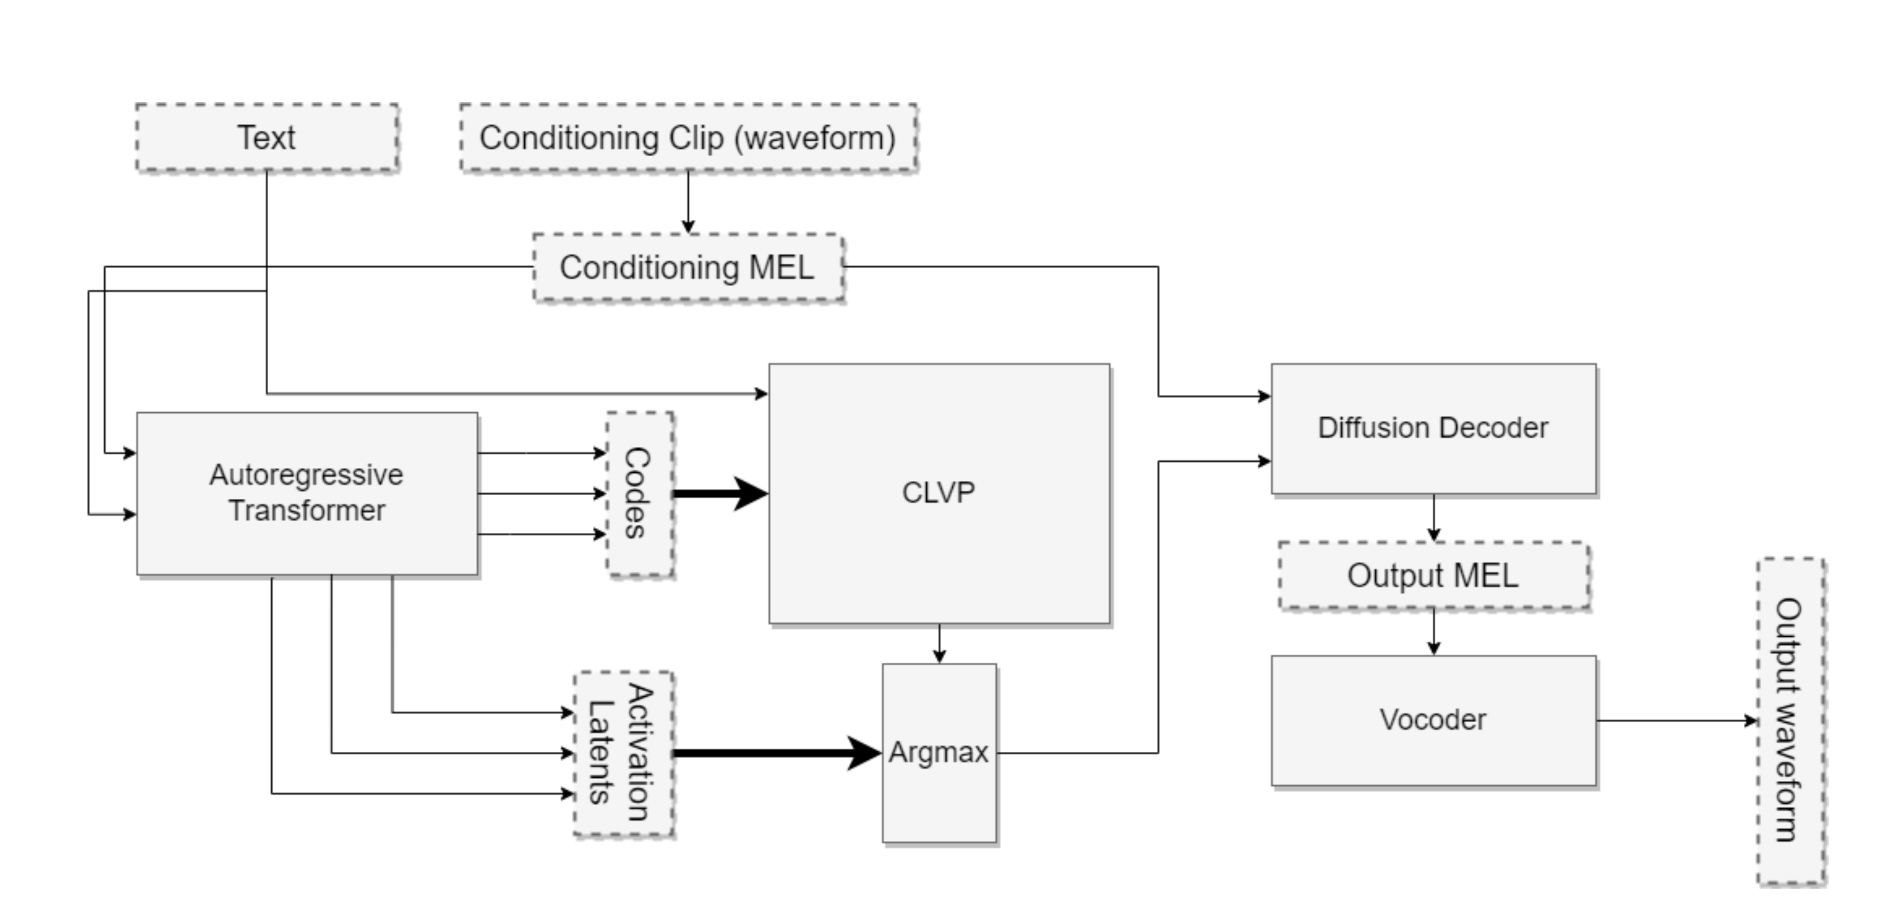


## 1. VQ-VAE


paper: [Neural Discrete Representation Learning](https://arxiv.org/pdf/1711.00937)

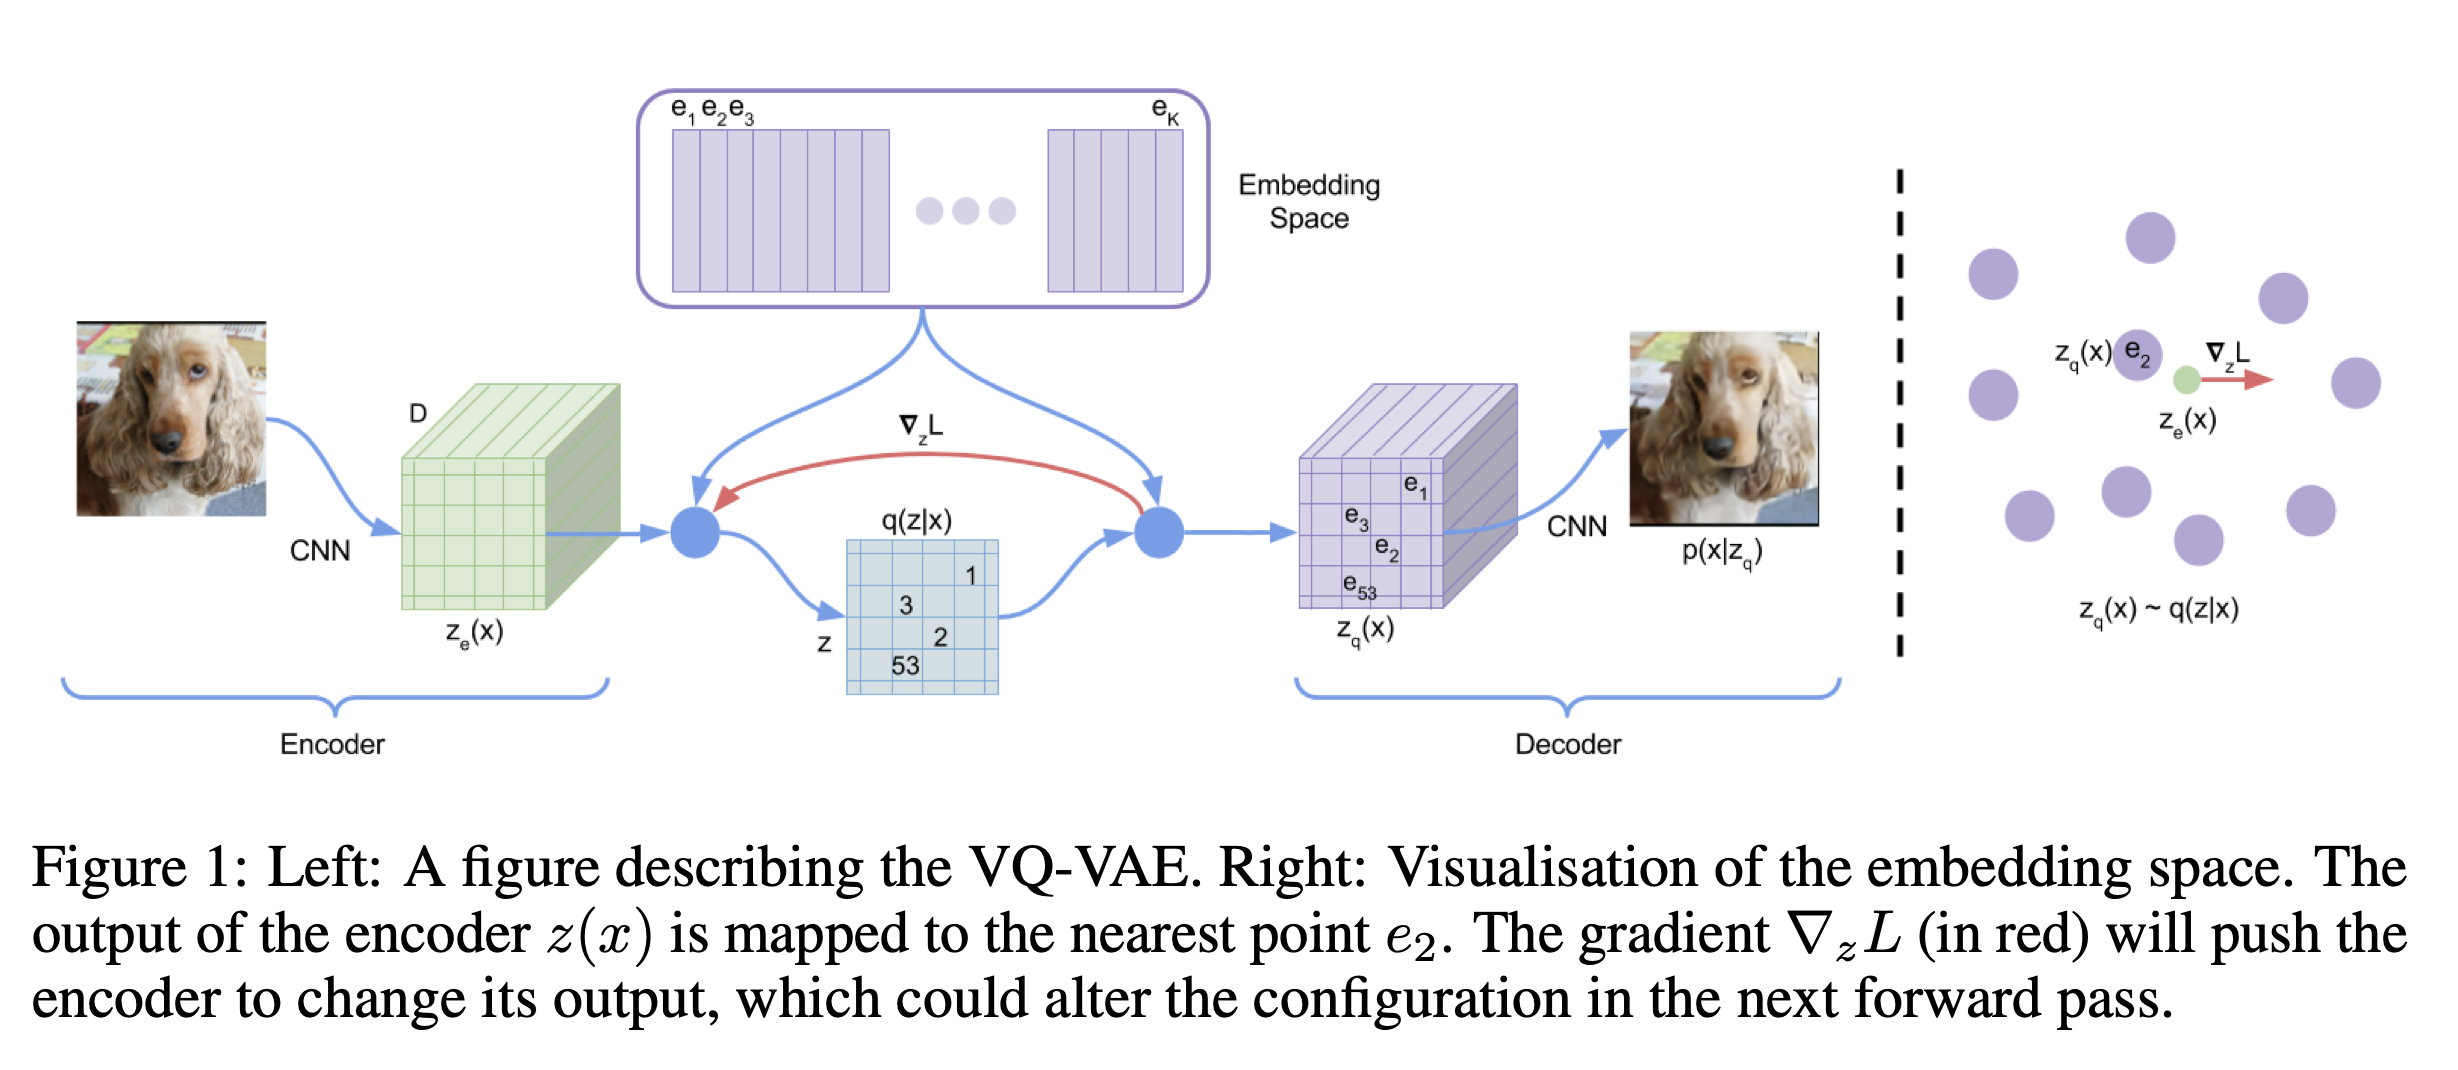

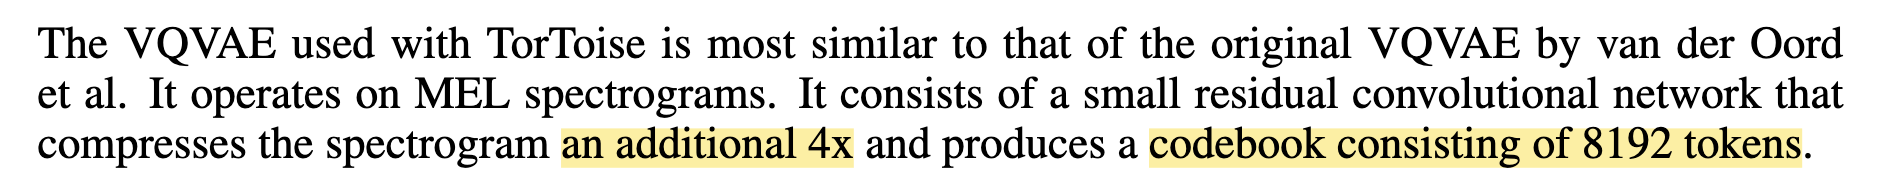


## Autoregressive Transformer


BPE 

check whisper lection

* causal attention
* transformer blocks
* shift loss

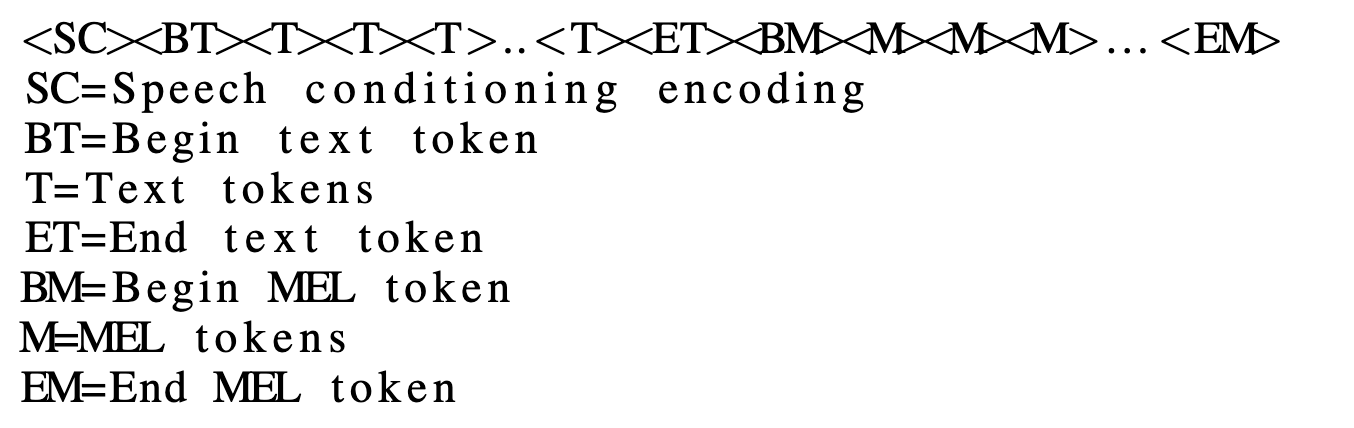

## Speaker conditioning

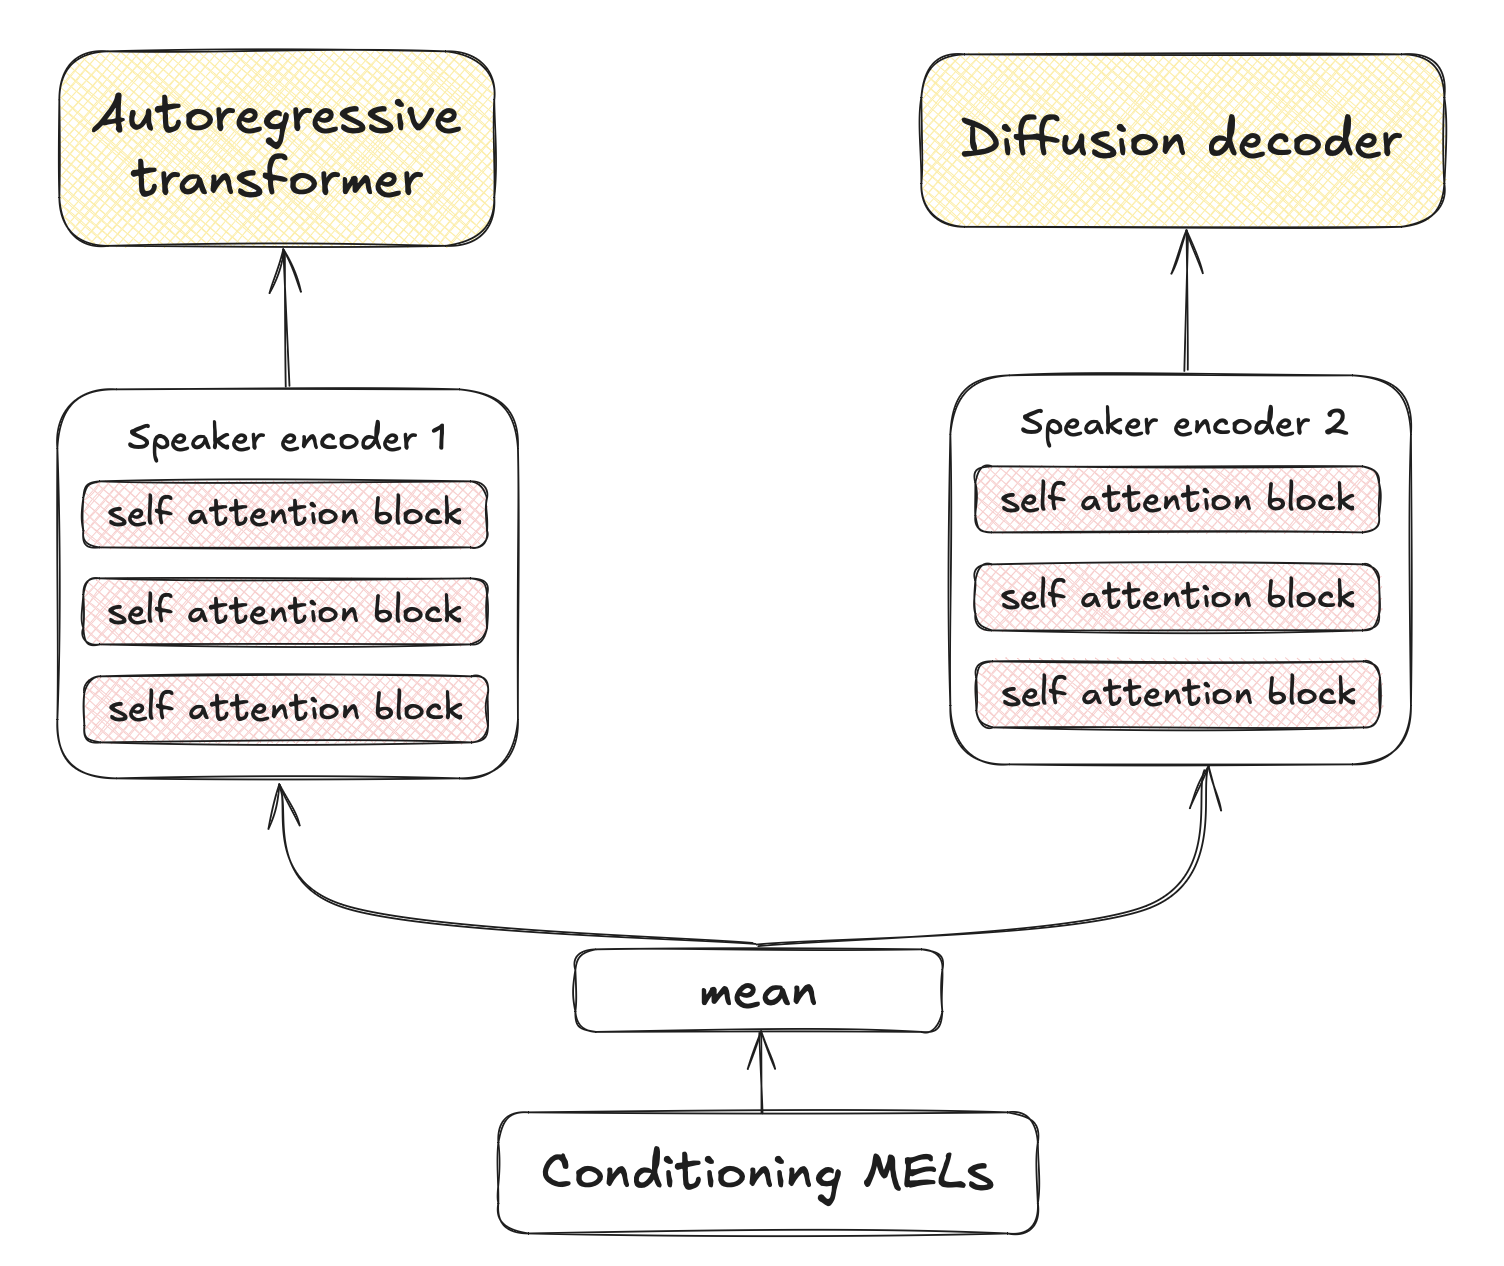

## Diffusion decoder

* DDIM
* latent input fine-tuning
* 

## CLVP

Contrastive Language-Voice Pretrained Transformer, inspired by CLIP

paper: [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/pdf/2103.00020)

* pretraining on matching pairs
* symmetric cross-entropy loss

Given a batch of N (image, text) pairs, CLIP is trained to predict which of the N × N possible (image, text) pairings across a batch actually occurred. To do this, CLIP learns a multi-modal embedding space by jointly training an image encoder and text encoder to maximize the cosine similar- ity of the image and text embeddings of the N real pairs in the batch while minimizing the cosine similarity of the embeddings of the N2 − N incorrect pairings.

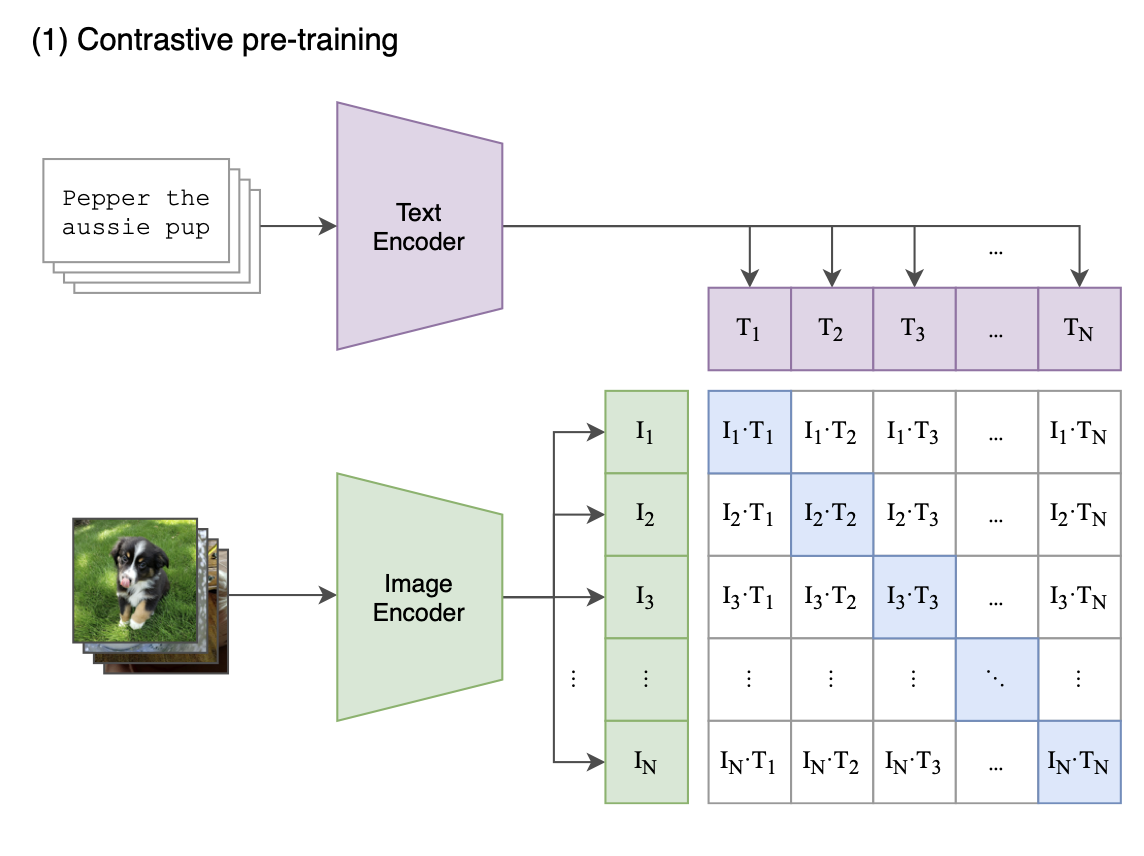

# Overview of TTS systems

## VALL-E (2023)

paper: [Neural Codec Language Models are Zero-Shot Text to Speech Synthesizers](https://arxiv.org/pdf/2301.02111)

* codec with RVQ
* AR transformer for the first RVQ layer
* non-AR transformer for all other layers
* speaker conditioning without separate encoder

### Encodec

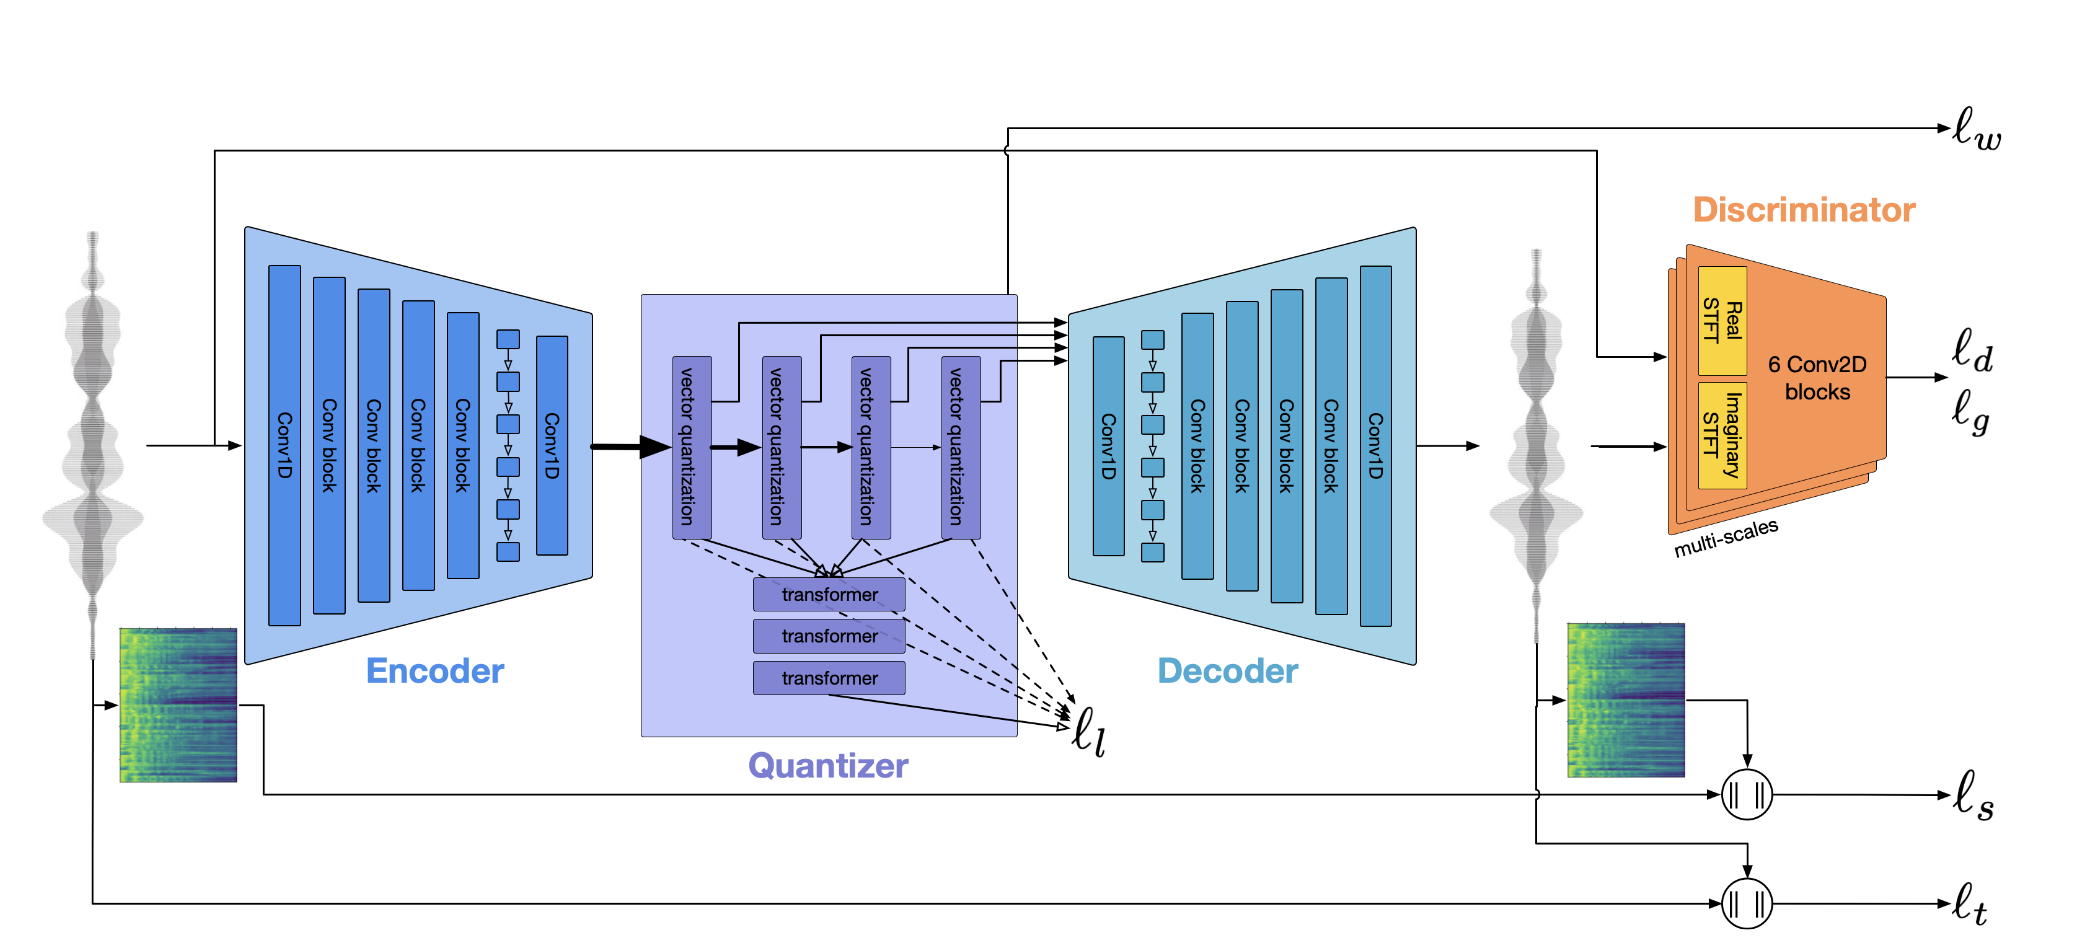

### VALL-E

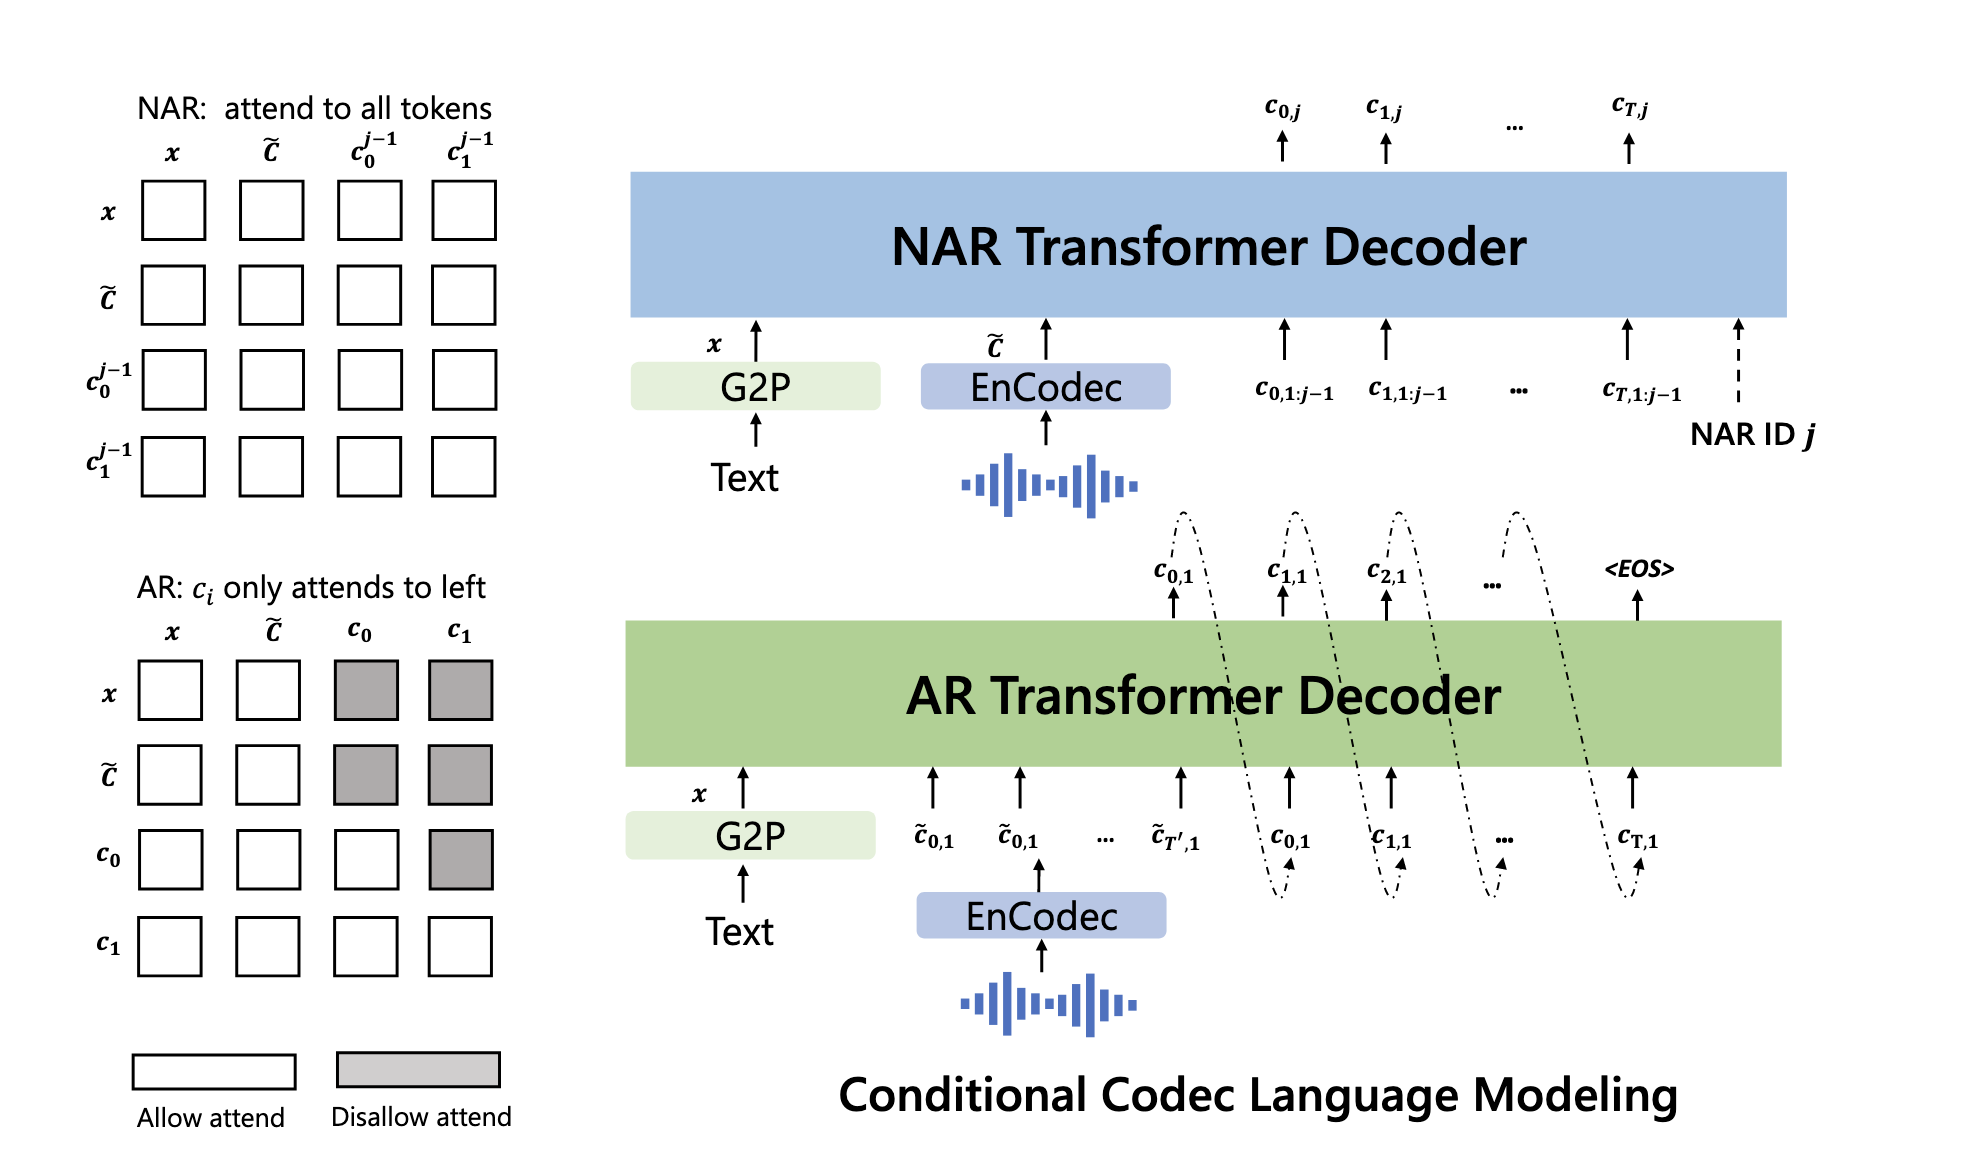

## xTTS v2 (2024)

paper: [XTTS: a Massively Multilingual Zero-Shot Text-to-Speech Model](https://arxiv.org/pdf/2406.04904) 

* pretrained speaker encoder
* cnn decoder

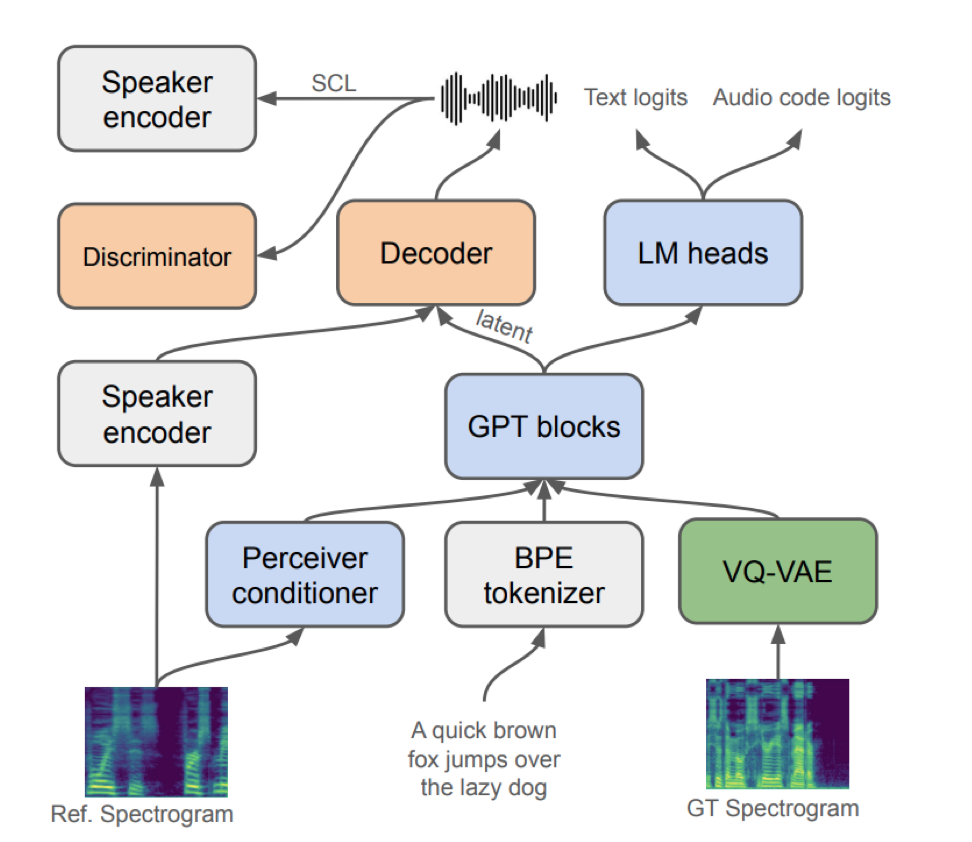

## CosyVoice 2 (2024)

paper: [CosyVoice 2: Scalable Streaming Speech Synthesis with Large Language Models](https://arxiv.org/pdf/2412.10117)

* Finite scalar quantization (FSQ) for VQ-VAE
* 


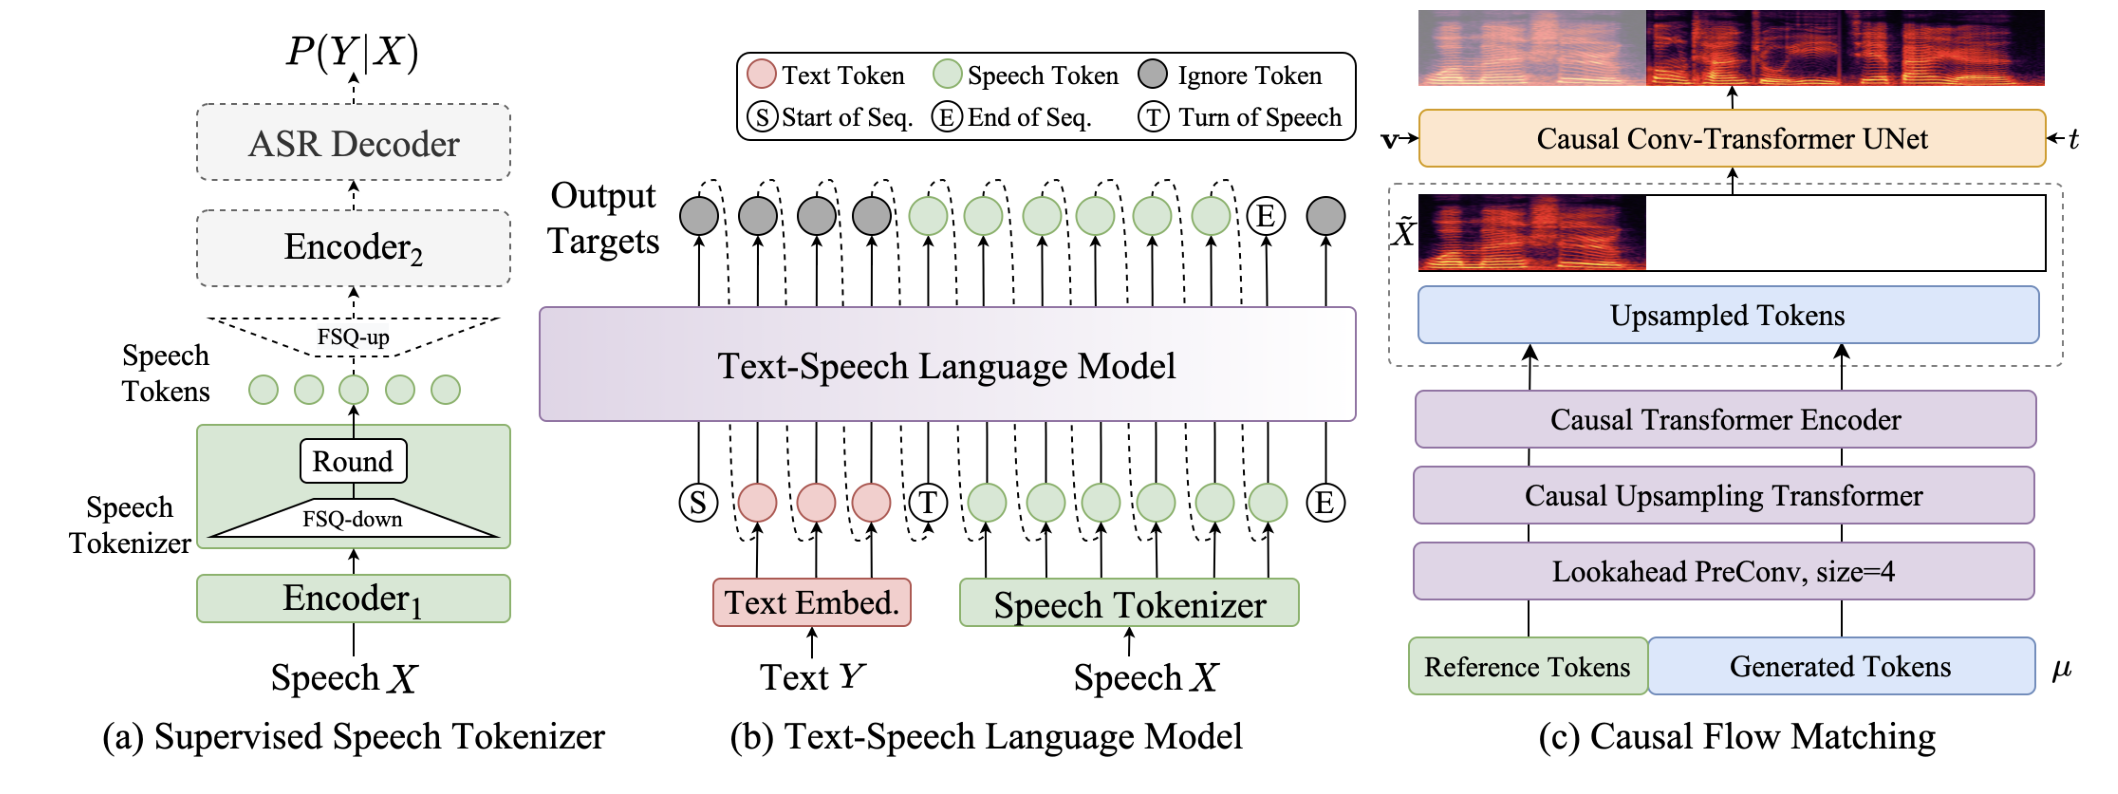

## Parler TTS (2024)

paper: [Natural language guidance of high-fidelity text-to-speech with synthetic annotations](https://arxiv.org/pdf/2402.01912)

* AR for all RVQ layers with delayed pattern
* Speaker conditioning via cross-attention

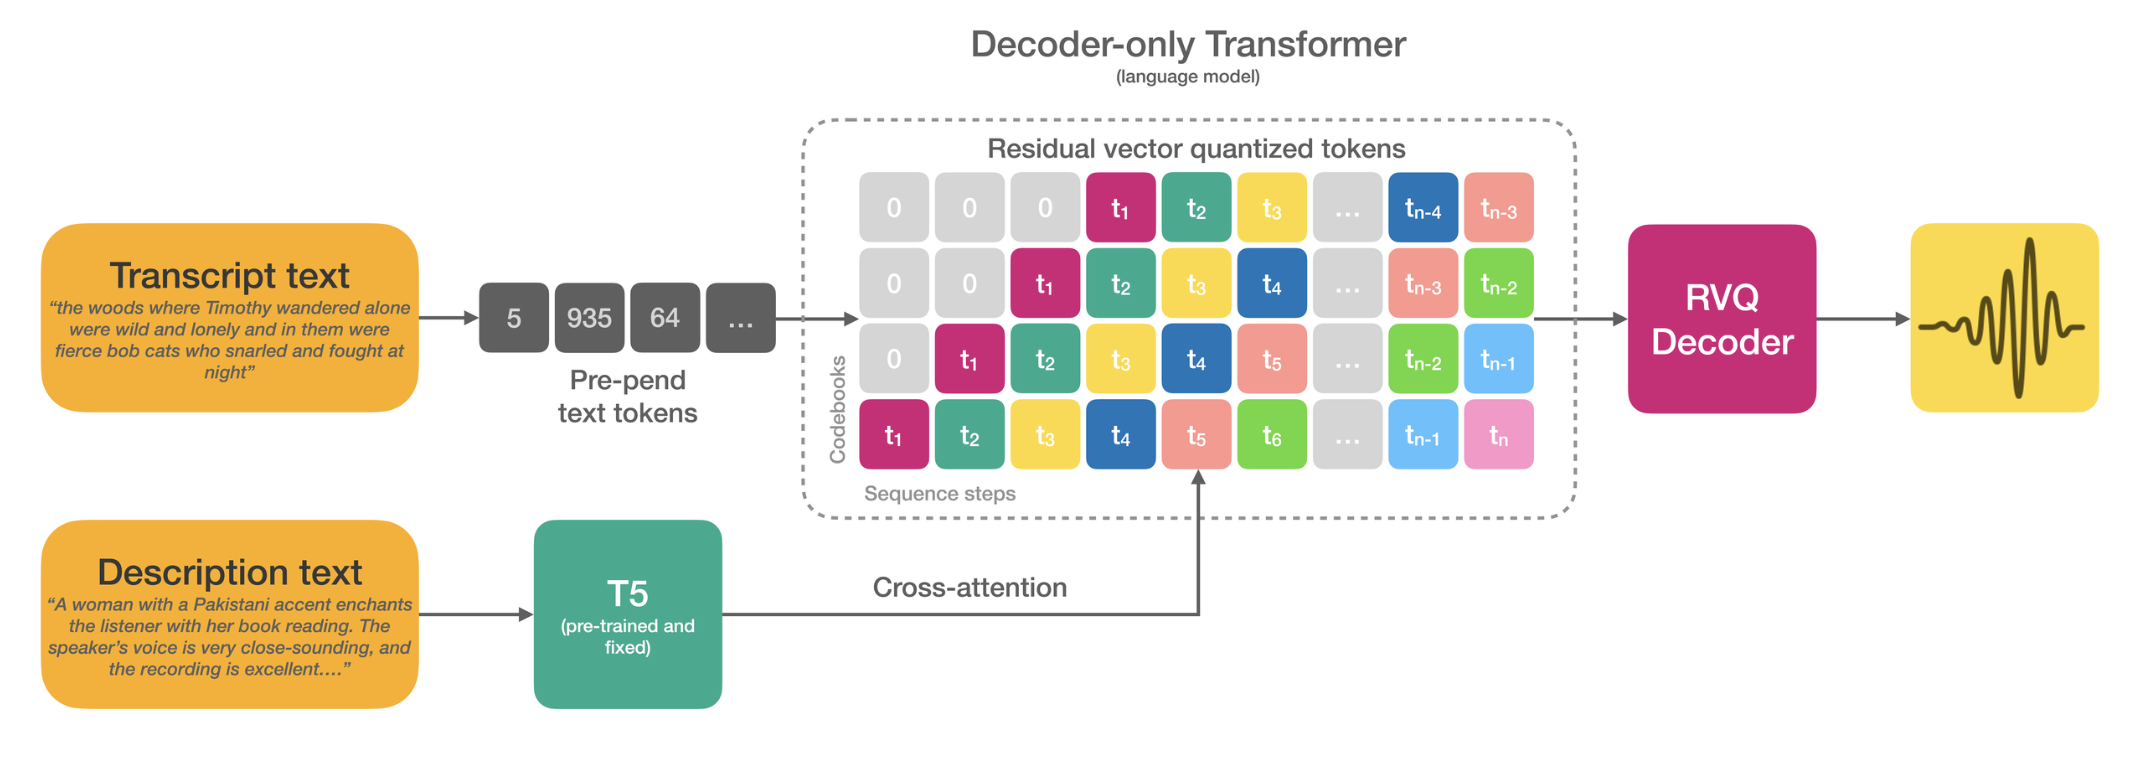

# Training LLM TTS 

1) gpt2 + one word dataset + pretrained vq

1.1) digits-only + gpt2

1.2) one-word + gpt2 kaggle

1.3) vctk + gpt2 kaggle


2) xtts fine-tune

* pretrained vq
* bpe tokenazir
* gpt2
* diffusion (pre-trained?) 

Inference of all blocks separately and full untrained pipeline

## 1. Dataset

LJspeech: https://www.kaggle.com/datasets/mathurinache/the-lj-speech-dataset

In [1]:
import torchaudio
import os

root_dir = "./LJSpeech" 
os.makedirs(root_dir, exist_ok=True)

ljspeech_dataset = torchaudio.datasets.LJSPEECH(root=root_dir, download=True)

waveform, sample_rate, transcript, normalized_transcript = ljspeech_dataset[0]

print("Waveform shape:", waveform.shape)
print("Sample rate:", sample_rate)
print("Transcript:", transcript)

Waveform shape: torch.Size([1, 212893])
Sample rate: 22050
Transcript: Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition


In [2]:
from IPython import display

display.Audio(waveform, rate=sample_rate)

## 2. VQ-VAE

In [12]:
from datasets import load_dataset, Audio
from transformers import EncodecModel, AutoProcessor

model = EncodecModel.from_pretrained("facebook/encodec_24khz")
processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")
# inputs = processor(raw_audio=waveform, sampling_rate=processor.sampling_rate, return_tensors="pt")
inputs = processor(raw_audio=waveform[0], sampling_rate=processor.sampling_rate, return_tensors="pt")

encoder_outputs = model.encode(inputs["input_values"], inputs["padding_mask"])
audio_values = model.decode(encoder_outputs.audio_codes, encoder_outputs.audio_scales, inputs["padding_mask"])[0]
# or the equivalent with a forward pass
audio_values = model(inputs["input_values"], inputs["padding_mask"]).audio_values

In [16]:
display.Audio(audio_values[0].cpu().detach(), rate=processor.sampling_rate)

## 3. LLM

In [17]:
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

## 4. Vocoder

# Homework

Theory (4 points):
Answer theory questions in the Google Form.

Practice (14 Points)

1. Put together training pipeline with torch or lightning:
    * resampling 
    * vqvae encoder
    * text tokenizer
1. Complete the gptTTS code 
1. Train gpt2 for TTS task
1. Run inference with different sampling strategies 
1. [optional] Setup UTMOS metric